# Exploratory Data Analysis

First, import pickle file with merged datasets, derived features, SP&500 Index, key fixes, and target variables.

In [2]:
# Quality of life
import os
import time
import warnings
from collections import defaultdict

# I/O and data structures
import pickle
import pandas as pd
import numpy as np

# Stats
from scipy import stats
from patsy import dmatrices
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from yellowbrick.features import Rank2D
from matplotlib import cm
from yellowbrick.features.importances import FeatureImportances
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Magic
%matplotlib inline
%load_ext pycodestyle_magic
%config InlineBackend.figure_format = 'retina'

sns.set_style('darkgrid')

In [4]:
# Import
inpath = "model_dictionary.pickle"
with open(inpath, 'rb') as f:
    modeling = pickle.load(f)

In [5]:
# Pull out the features dataframe
train = modeling['features']

In [6]:
# Set a feature selection list
features = ['High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Year',
            'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Pct_Change_Daily',
            'Pct_Change_Monthly', 'Pct_Change_Yearly', 'RSI', 'Volatility',
            'Yearly_Return_Rank', 'Monthly_Return_Rank', 'Pct_Change_Class',
            'Rolling_Yearly_Mean_Positive_Days', 'Rolling_Monthly_Mean_Positive_Days', 
            'Rolling_Monthly_Mean_Price', 'Rolling_Yearly_Mean_Price',
            'Momentum_Quality_Monthly', 'Momentum_Quality_Yearly', 'SPY_Trailing_Month_Return',
            'open_l1', 'open_l5', 'open_l10', 'close_l1', 'close_l5', 'close_l10',
            'return_prev1_open_raw', 'return_prev5_open_raw', 'return_prev10_open_raw',
            'return_prev1_close_raw', 'return_prev5_close_raw', 'return_prev10_close_raw',
            'pe_ratio', 'debt_ratio', 'debt_to_equity', 'roa',
            'beta']

In [7]:
# Select on features to pass to modeling machinery, along with necessary indexers
X = train[features]
tickers = train['ticker'].unique().tolist()

In [8]:
# Explore the data types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007856 entries, 0 to 1007855
Data columns (total 44 columns):
High                                  1007856 non-null float64
Low                                   1007856 non-null float64
Open                                  1007856 non-null float64
Close                                 1007856 non-null float64
Volume                                1007856 non-null float64
AdjClose                              1007856 non-null float64
Year                                  1007856 non-null int64
Month                                 1007856 non-null int64
Week                                  1007856 non-null int64
Day                                   1007856 non-null int64
Dayofweek                             1007856 non-null int64
Dayofyear                             1007856 non-null int64
Pct_Change_Daily                      1007818 non-null float64
Pct_Change_Monthly                    1007038 non-null float64
Pct_Change_Yearly

In [9]:
df = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

Summary statistics

In [10]:
# Descriptive stats
df.describe()

High            Low           Open          Close  \
count  835905.000000  835905.000000  835905.000000  835905.000000   
mean       83.523763      81.921281      82.731623      82.746892   
std       104.360476     102.333937     103.376613     103.368119   
min         1.690000       1.610000       1.620000       1.620000   
25%        37.900002      37.169998      37.540001      37.549999   
50%        60.480000      59.310001      59.900002      59.910000   
75%        95.480003      93.750000      94.629997      94.629997   
max      2228.989990    2174.070068    2210.929932    2206.090088   

             Volume       AdjClose           Year          Month  \
count  8.359050e+05  835905.000000  835905.000000  835905.000000   
mean   4.634139e+06      78.554458    2015.205582       6.391098   
std    1.017982e+07     103.165156       2.094172       3.466078   
min    0.000000e+00       1.620000    2011.000000       1.000000   
25%    1.045700e+06      34.104759    2013.000000       3.000000   
50%    2.106000e+06      55.360001    2015.000000       6.000000   
75%    4.505500e+06      89.537498    2017.000000       9.000000   
max    6.694799e+08    2206.090088    2019.000000      12.000000   

                Week            Day  ...  return_prev5_open_raw  \
count  835905.000000  835905.000000  ...          835905.000000   
mean       25.985102      15.731991  ...               0.296933   
std        15.116271       8.745304  ...               3.601203   
min         1.000000       1.000000  ...             -40.265252   
25%        13.000000       8.000000  ...              -1.522911   
50%        26.000000      16.000000  ...               0.334896   
75%        39.000000      23.000000  ...               2.159342   
max        53.000000      31.000000  ...              78.616293   

       return_prev10_open_raw  return_prev1_close_raw  return_prev5_close_raw  \
count           835905.000000           835905.000000           835905.000000   
mean                 0.593121                0.068447                0.339094   
std                  5.035763                1.630156                3.614157   
min                -48.263517              -41.815163              -42.798551   
25%                 -2.061588               -0.691419               -1.464684   
50%                  0.632680                0.076509                0.386723   
75%                  3.272733                0.848988                2.196489   
max                 90.101947               61.906564               73.551685   

       return_prev10_close_raw       pe_ratio     debt_ratio  debt_to_equity  \
count            835905.000000  835905.000000  835905.000000   835905.000000   
mean                  0.677594      70.402793      13.185044       13.185044   
std                   5.047189    2120.164251    1164.759133     1164.759133   
min                 -46.341463 -142977.192841   -2490.600000    -2490.600000   
25%                  -1.965631      42.805806       0.893033        0.893033   
50%                   0.720141      68.382650       1.578100        1.578100   
75%                   3.349509     103.420353       2.961196        2.961196   
max                  91.103790   90233.485373  132900.000000   132900.000000   

                roa           beta  
count  8.359050e+05  835905.000000  
mean   1.162370e+03       0.446234  
std    1.336893e+05       0.677219  
min   -3.488220e+00      -2.435510  
25%    5.518510e-03       0.161467  
50%    1.403298e-02       0.307650  
75%    2.564883e-02       0.523910  
max    1.540000e+07      11.483401  

[8 rows x 44 columns]

Correlation

In [11]:
# Feature correlation in descending order
corr = df.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

beta                                beta                                  1.000000
Rolling_Monthly_Mean_Price          Rolling_Monthly_Mean_Price            1.000000
Momentum_Quality_Monthly            Momentum_Quality_Monthly              1.000000
Momentum_Quality_Yearly             Momentum_Quality_Yearly               1.000000
SPY_Trailing_Month_Return           SPY_Trailing_Month_Return             1.000000
open_l1                             open_l1                               1.000000
open_l5                             open_l5                               1.000000
open_l10                            open_l10                              1.000000
close_l1                            close_l1                              1.000000
close_l5                            close_l5                              1.000000
close_l10                           close_l10                             1.000000
return_prev1_open_raw               return_prev1_open_raw                 1.000000
retu

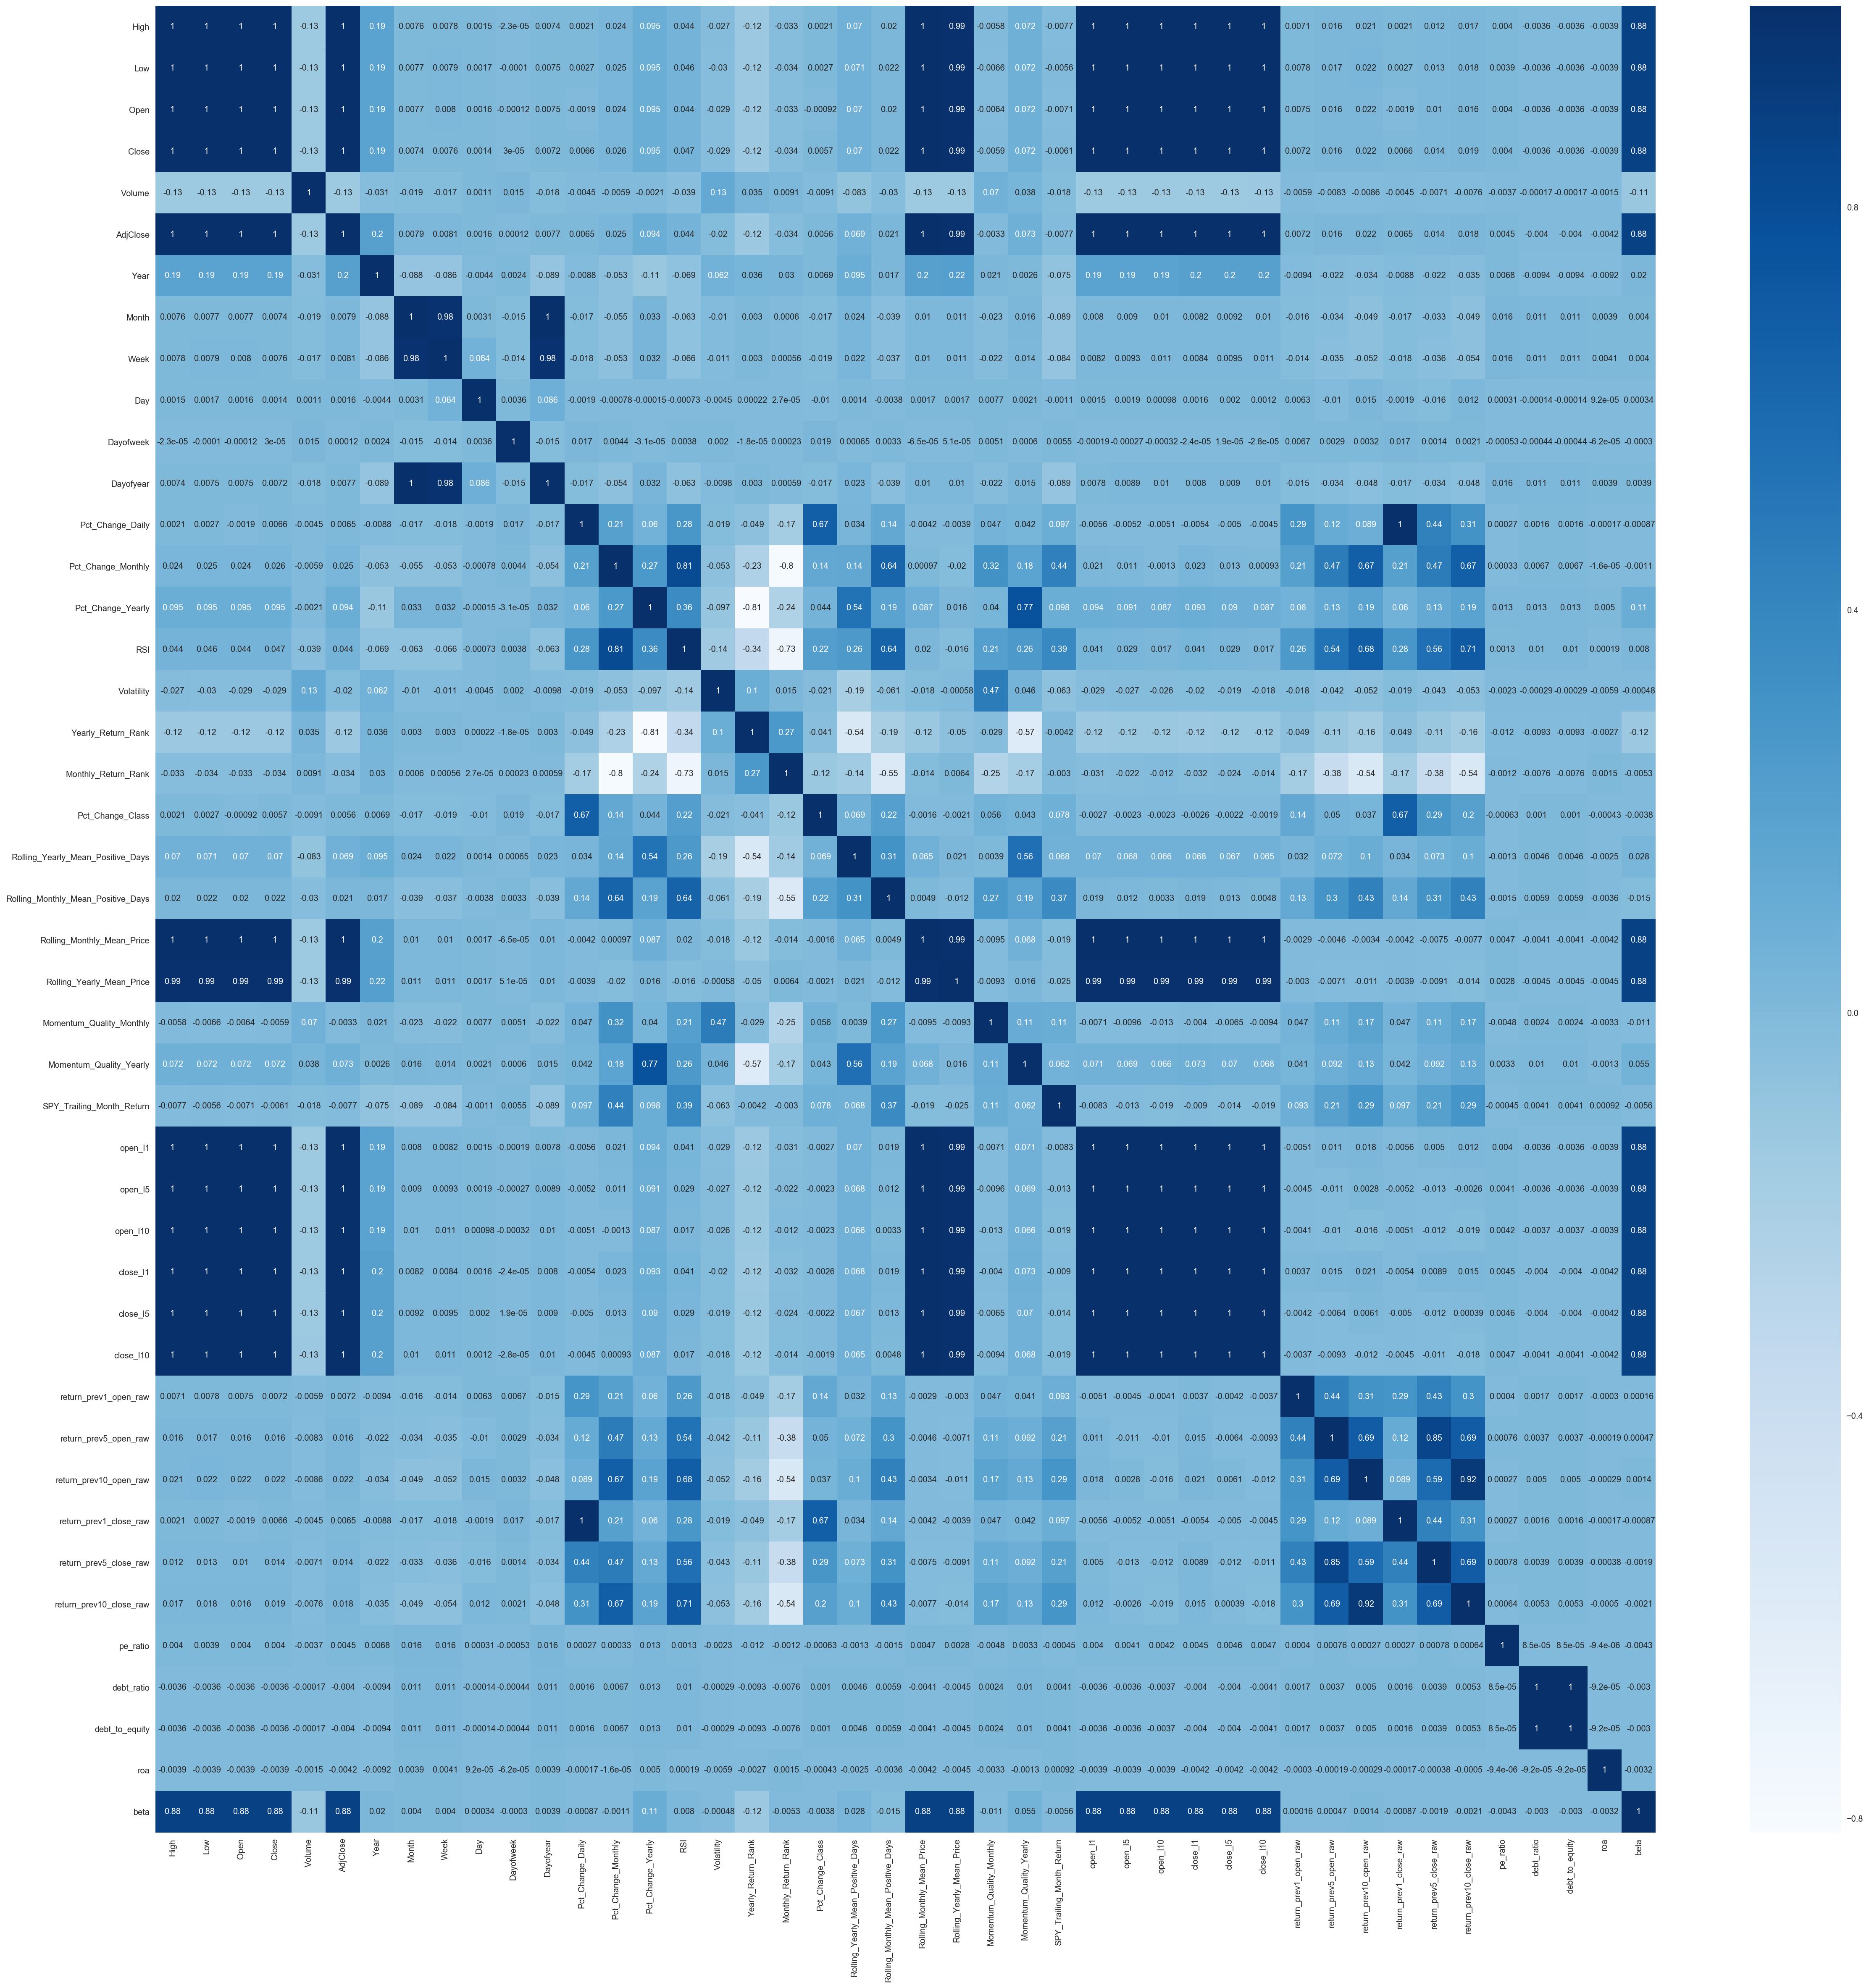

In [12]:
# Using Pearson correlation with numbers to demonstrate feature correlation
plt.figure(figsize=(40,40))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

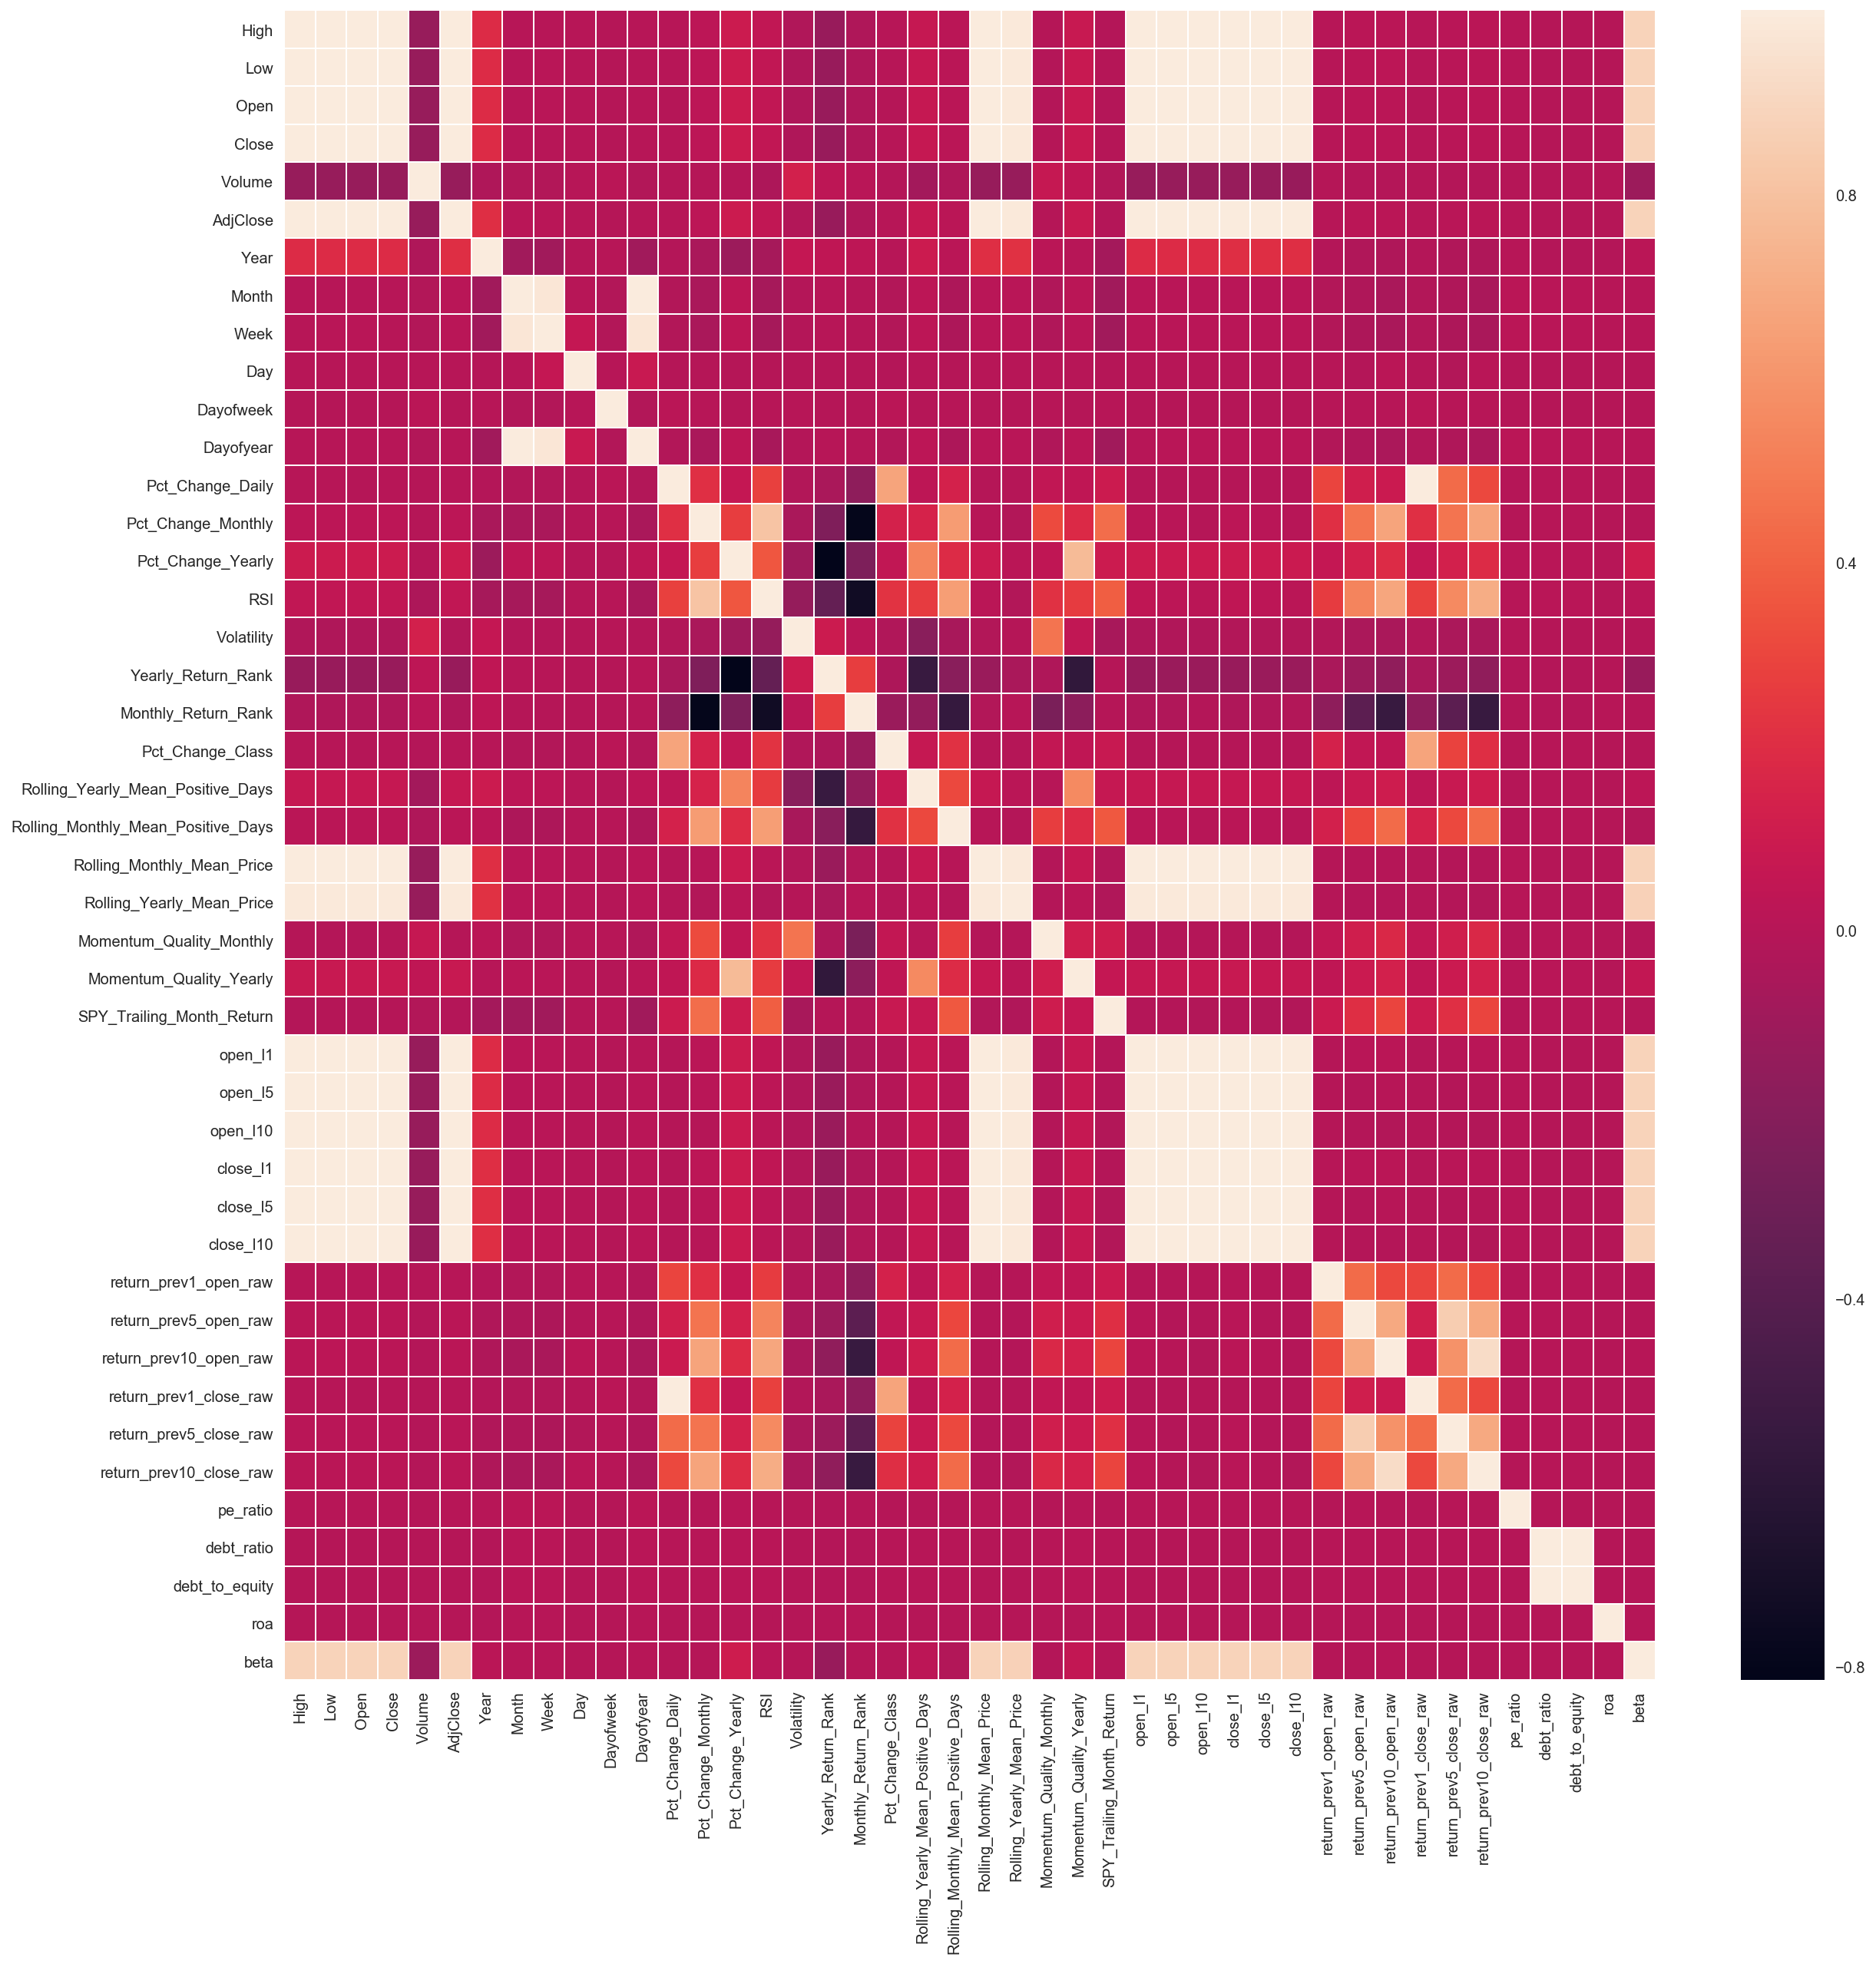

In [13]:
# Using Pearson ranking without numbers
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)

Covariance

In [14]:
# Features covariance in descending order
cov = df.cov()
c2 = cov.abs().unstack()
c2.sort_values(ascending = False)

Volume                             Volume                               1.036287e+14
roa                                roa                                  1.787284e+10
                                   Volume                               2.058379e+09
Volume                             roa                                  2.058379e+09
High                               Volume                               1.372895e+08
Volume                             High                                 1.372895e+08
Close                              Volume                               1.365230e+08
Volume                             Close                                1.365230e+08
                                   Open                                 1.364009e+08
Open                               Volume                               1.364009e+08
Volume                             open_l1                              1.361706e+08
open_l1                            Volume                        

Droping infinite and NA values

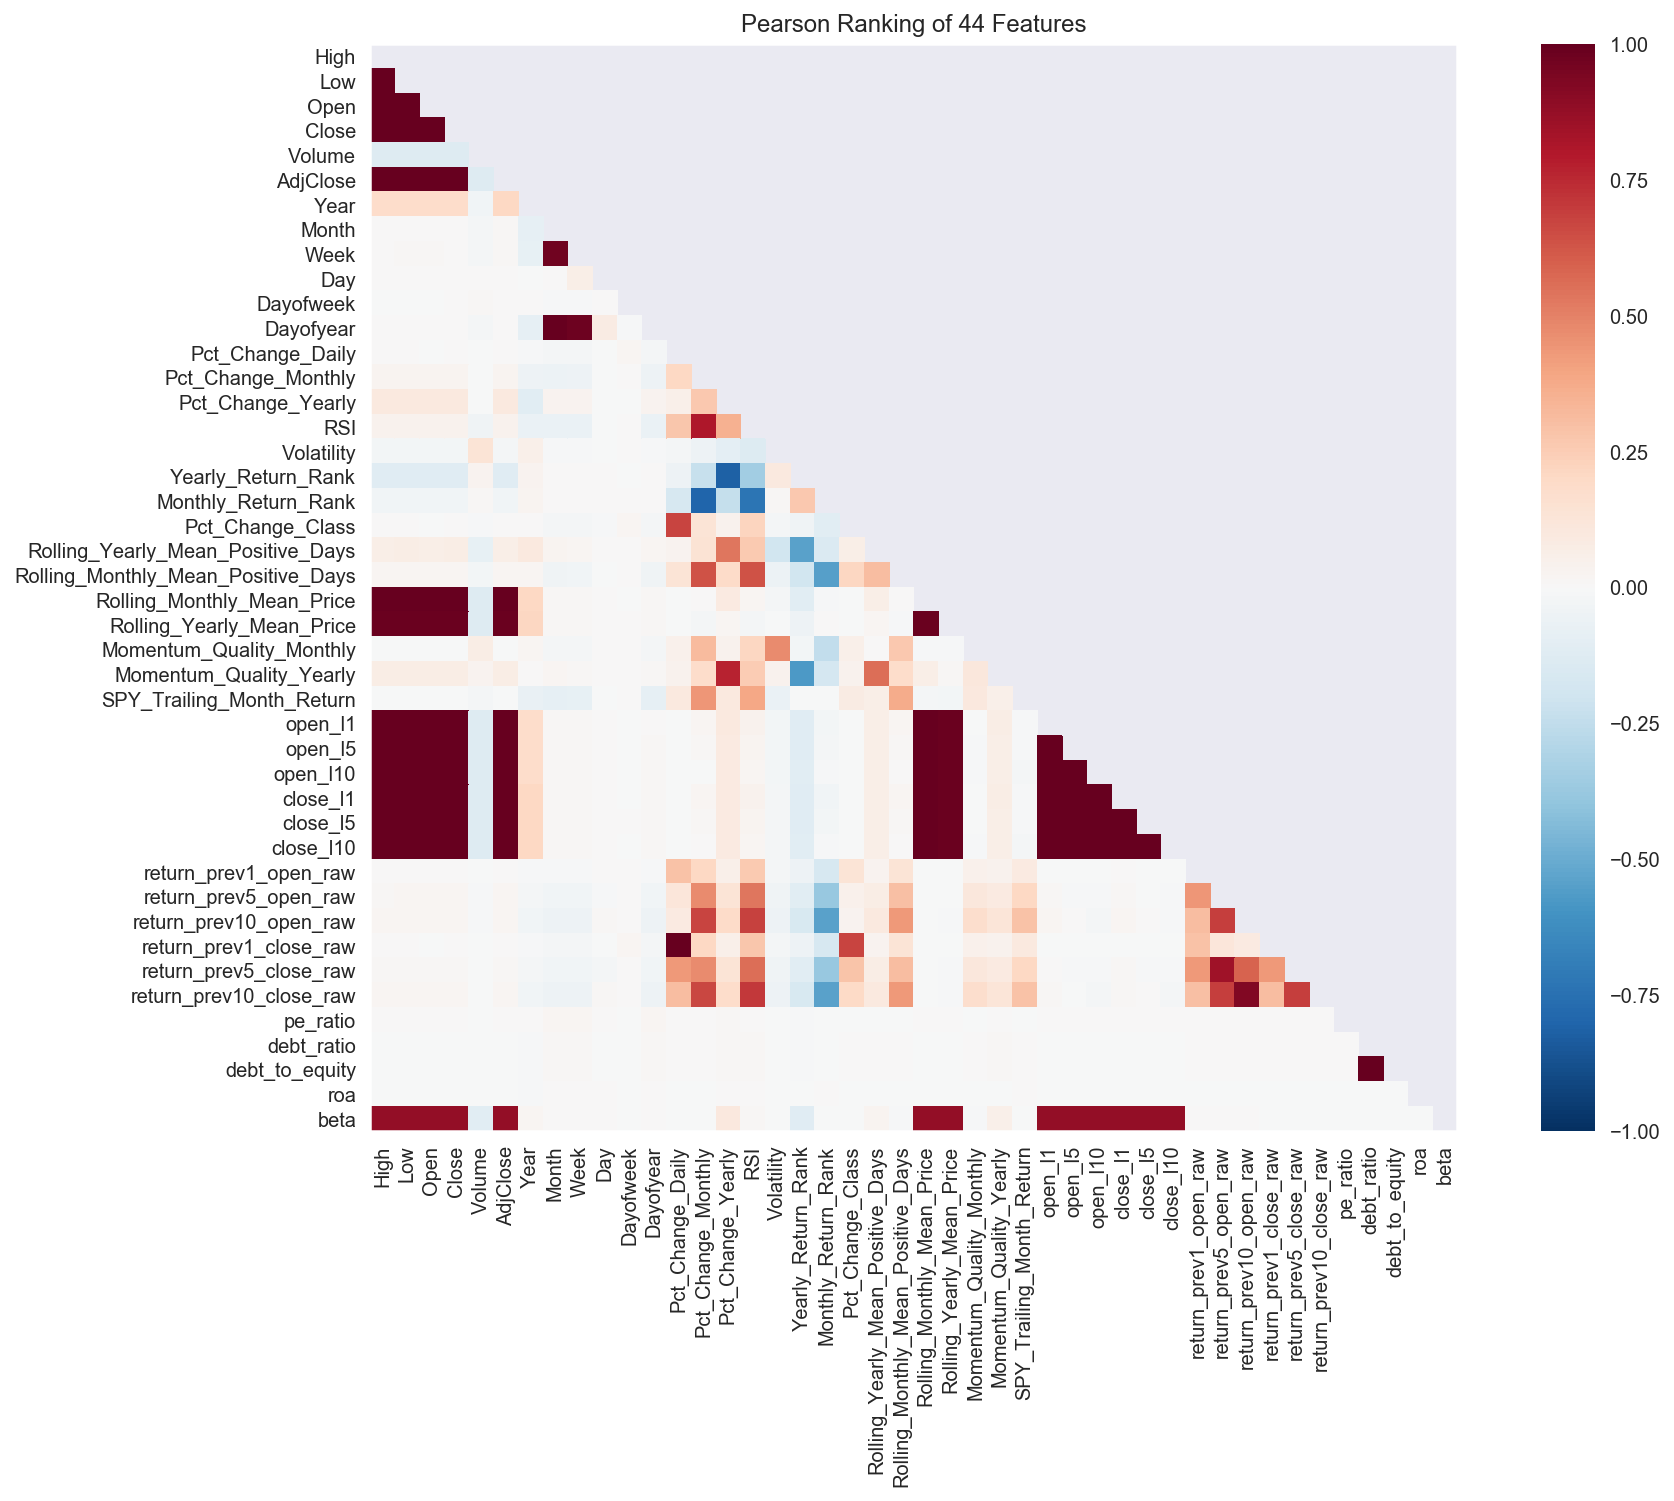

In [15]:
# Another Pearson correlation of all features
features = df.keys()
visualizer = Rank2D(features=features, algorithm='pearson',size=(1080,720))

visualizer.fit(df.values)                
visualizer.transform(df.values)             
visualizer.poof()

Univariate analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1eaa8da0>,
      dtype=object)

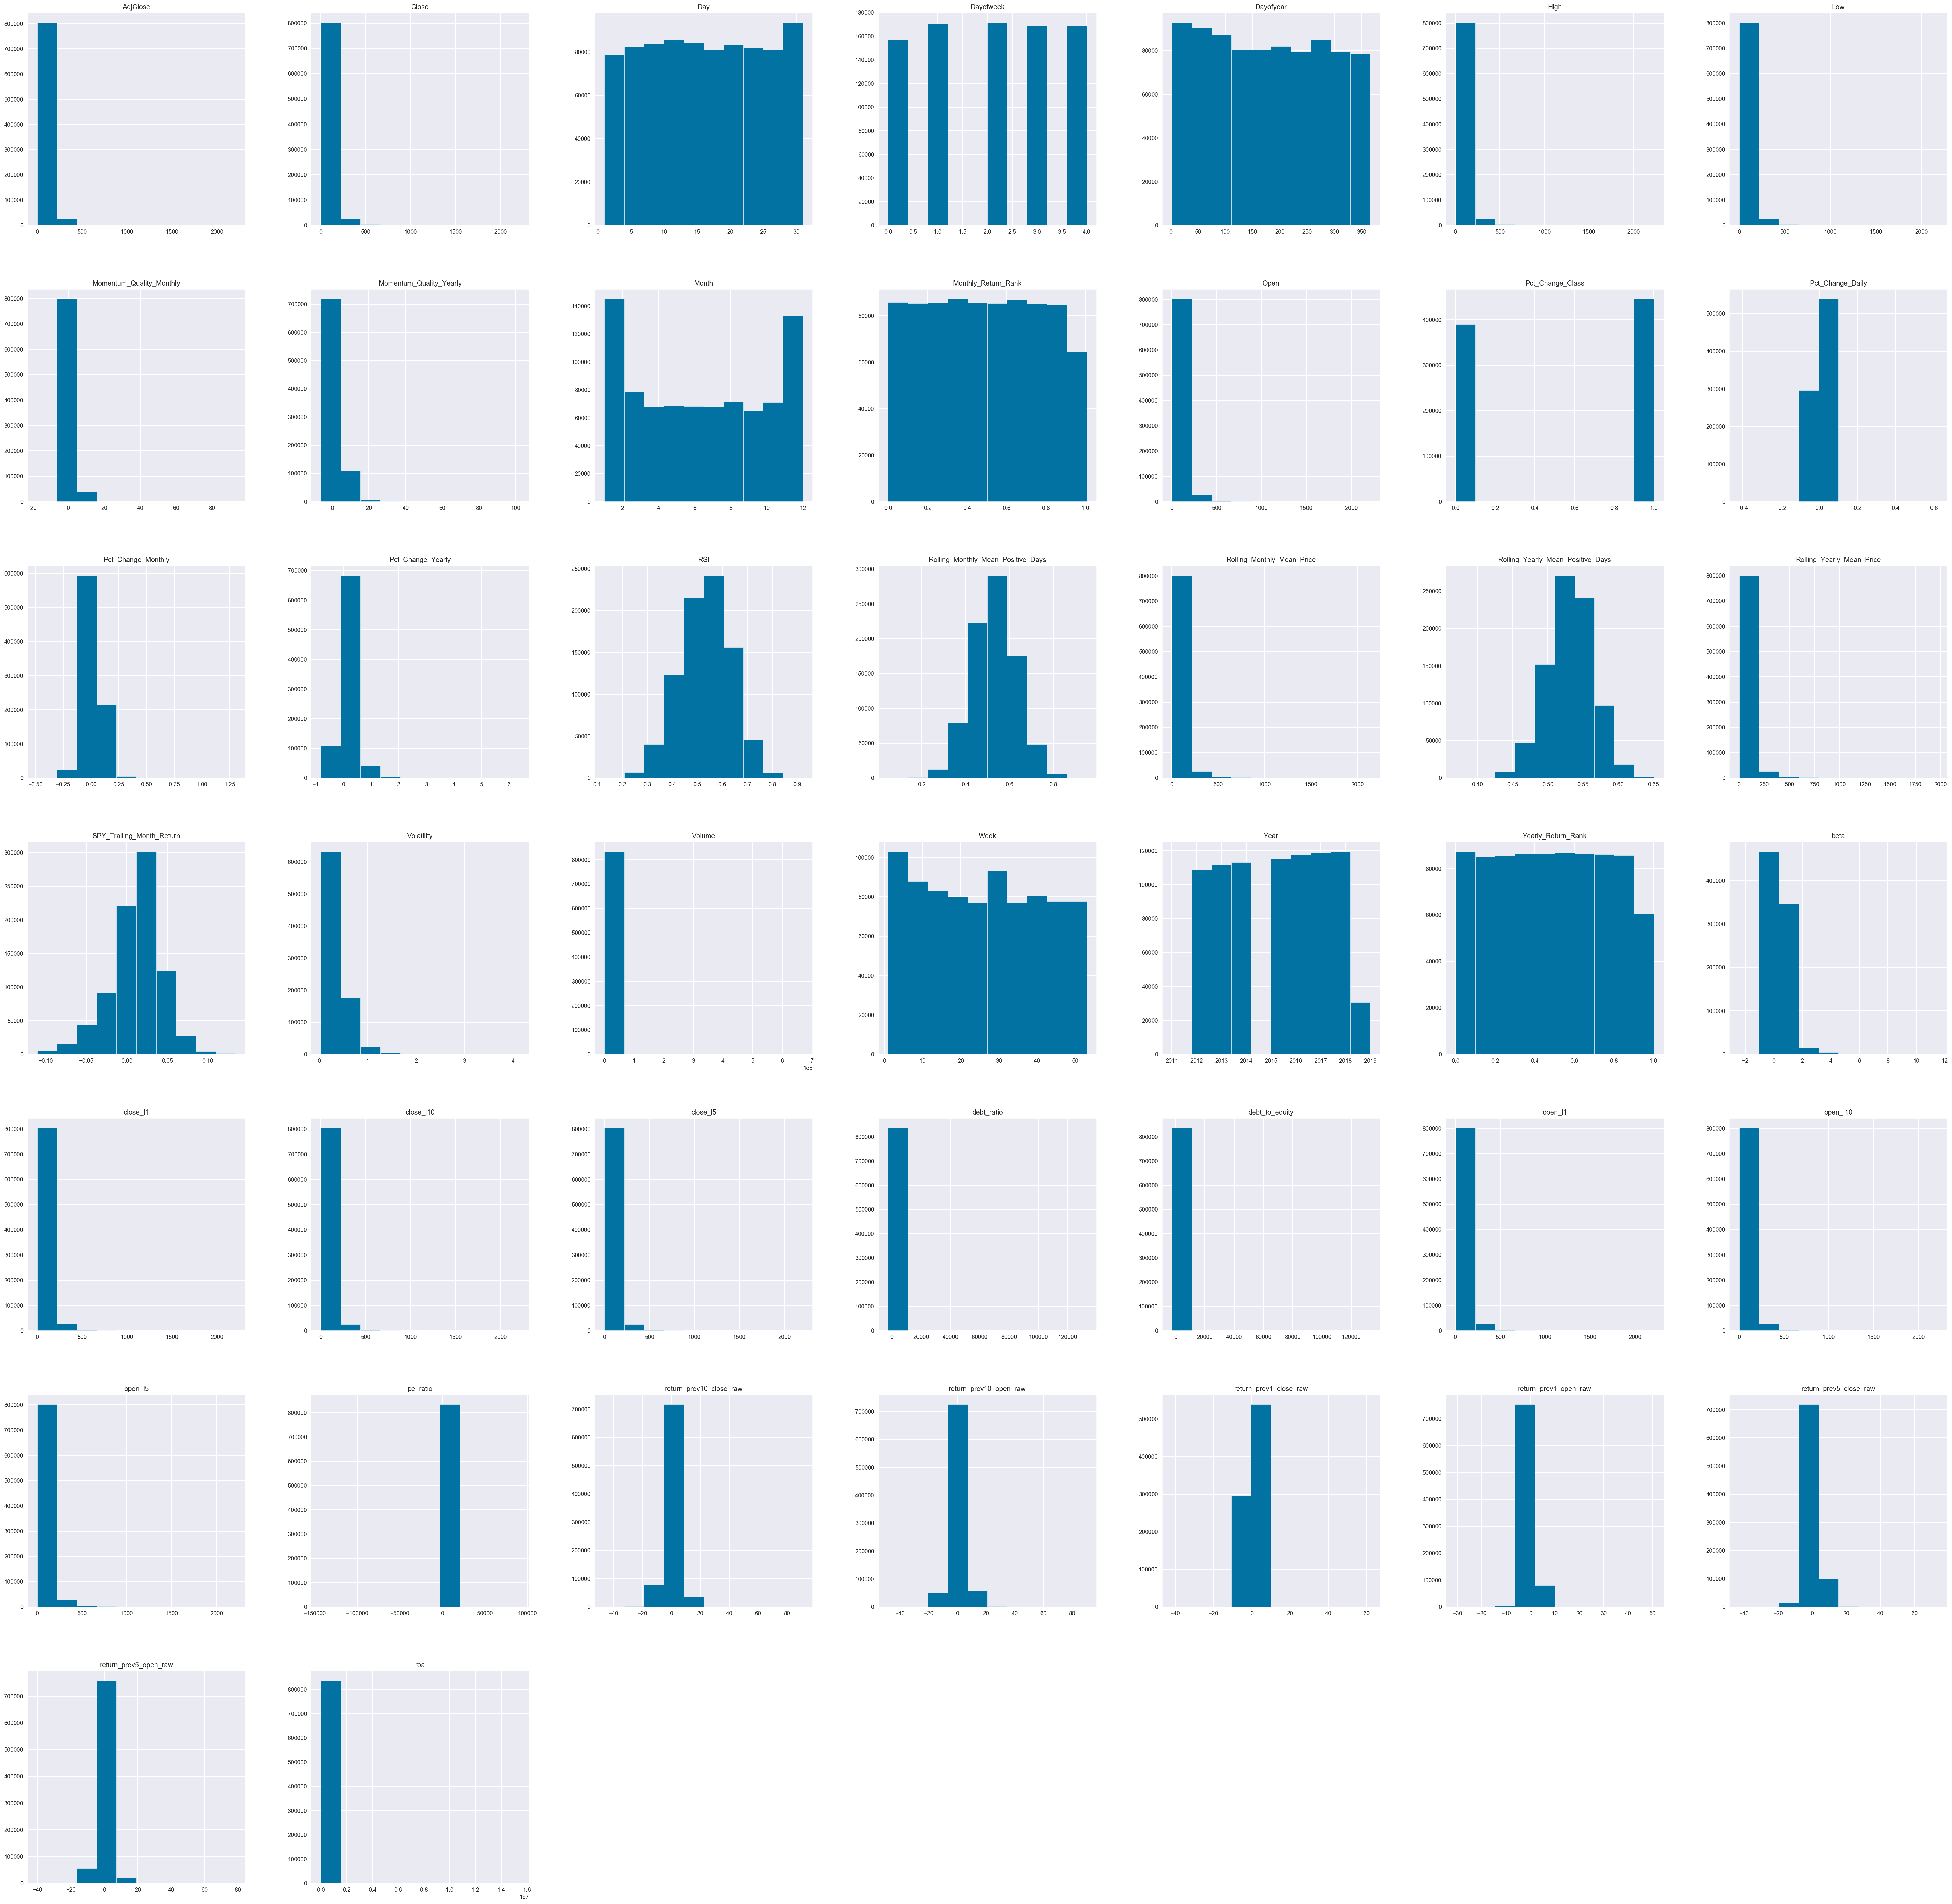

In [16]:
# Histogram of all features
df.hist(figsize=(60,60)) 

Select the target variable

In [18]:
# Choose a ticker
target = modeling['target_21_rel_return']

In [19]:
# Selecting the target variable
X = df.iloc[:,:-1] # independent variables X
y = target # dependent Variables y

Multivariate analysis

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


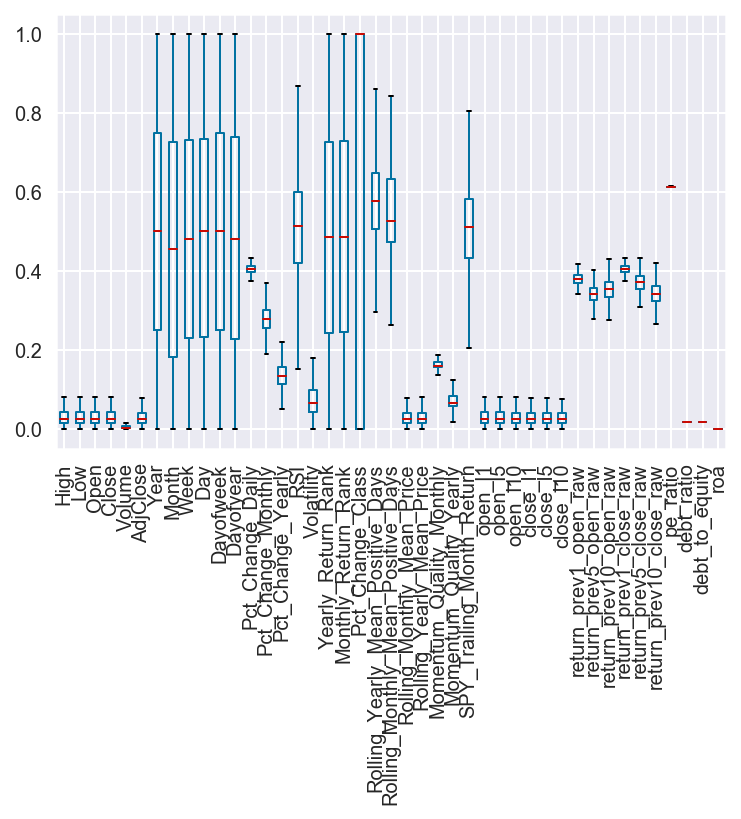

In [29]:
# Data after Scaling Using MinMax Scaler
minmax_scaler =  MinMaxScaler(feature_range=(0, 1)) 
X_minmax = minmax_scaler.fit(X).transform(X)
X_minmax = pd.DataFrame(X_minmax)
X_minmax.columns = X.columns
cols2 = pd.DataFrame(X_minmax)
cols2 = list(cols2.columns)
boxplot = X_minmax.boxplot(column=cols2, rot=90, fontsize=10)

In [30]:
#Correlation with target variable #1
cor_target = abs(cor["AdjClose"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

High                          0.998794
Low                           0.998725
Open                          0.998685
Close                         0.998829
AdjClose                      1.000000
Rolling_Monthly_Mean_Price    0.998760
Rolling_Yearly_Mean_Price     0.987472
open_l1                       0.998466
open_l5                       0.997608
open_l10                      0.996634
close_l1                      0.999786
close_l5                      0.998945
close_l10                     0.997987
beta                          0.880088
Name: AdjClose, dtype: float64

Feature correlation with potential target variables

In [31]:
#Correlation with target variable #2
cor_target = abs(cor["Monthly_Return_Rank"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Pct_Change_Monthly                    0.799285
RSI                                   0.731103
Monthly_Return_Rank                   1.000000
Rolling_Monthly_Mean_Positive_Days    0.552446
return_prev10_open_raw                0.541319
return_prev10_close_raw               0.540280
Name: Monthly_Return_Rank, dtype: float64

In [32]:
#Correlation with target variable #3
cor_target = abs(cor["Yearly_Return_Rank"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Pct_Change_Yearly                    0.814234
Yearly_Return_Rank                   1.000000
Rolling_Yearly_Mean_Positive_Days    0.541710
Momentum_Quality_Yearly              0.574198
Name: Yearly_Return_Rank, dtype: float64

In [33]:
#Correlation with target variable #4
cor_target = abs(cor["return_prev1_close_raw"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Pct_Change_Daily          1.000000
Pct_Change_Class          0.672108
return_prev1_close_raw    1.000000
Name: return_prev1_close_raw, dtype: float64

In [34]:
#Correlation with target variable #5
cor_target = abs(cor["return_prev5_close_raw"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RSI                        0.560029
return_prev5_open_raw      0.851419
return_prev10_open_raw     0.590915
return_prev5_close_raw     1.000000
return_prev10_close_raw    0.692255
Name: return_prev5_close_raw, dtype: float64

In [35]:
#Correlation with target variable #6
cor_target = abs(cor["return_prev10_close_raw"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Pct_Change_Monthly         0.671347
RSI                        0.706303
Monthly_Return_Rank        0.540280
return_prev5_open_raw      0.691343
return_prev10_open_raw     0.924594
return_prev5_close_raw     0.692255
return_prev10_close_raw    1.000000
Name: return_prev10_close_raw, dtype: float64